In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload

from typing import Optional

/home/mmayer/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mmayer/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import sys
sys.path.append("..")

%autoreload 2
from pipeline import CameraCalibration, BirdsEyeView, ImageSection, Point
from scripts.channels import show_channels, show_single_image, show_two_images
from scripts.conversion import bgr2lab

In [43]:
friendly_paths = sorted(glob.glob(os.path.join('..', 'test_images', 'test*.jpg')))
hard_paths = sorted(glob.glob(os.path.join('..', 'test_images', 'challenge*.jpg')))

In [13]:
def get_test_image(i: int, resize: bool=True, hard: bool=True) -> np.ndarray:
    img = cv2.imread(hard_paths[i] if hard else friendly_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (0, 0), fx=0.25, fy=0.25) if resize else img

In [5]:
cc = CameraCalibration.from_pickle(os.path.join('..', 'calibration.pkl'))

section = ImageSection(
        top_left=Point(x=580, y=461.75),
        top_right=Point(x=702, y=461.75),
        bottom_right=Point(x=1013, y=660),
        bottom_left=Point(x=290, y=660),
    )

bev = BirdsEyeView(section,
                   section_width=3.6576,        # one lane width in meters
                   section_height=2 * 13.8826)  # two dash distances in meters

In [47]:
def lab_enhance_yellow(img: np.ndarray, power: float=1) -> np.ndarray:
    img = np.float32(img) / 255
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    rg = (127 - lab[..., 1]) / 256
    yb = (127 - lab[..., 2]) / 256

    yb[yb < 0.4] = 0  # suppress blue
    yb[rg < 0.2] = 0  # suppress red
    yb[rg > 0.8] = 0  # suppress green
    
    # Normalize "yellow channel" to 0..1
    cv2.normalize(yb, yb, 1, norm_type=cv2.NORM_MINMAX)
        
    # OpenCV L*a*b*'s L is 0..100 
    gray = lab[..., 0] / 100
    
    # We first add the channels, then pick renormalize.
    mixed = gray + yb    
    cv2.normalize(mixed, mixed, 1, norm_type=cv2.NORM_MINMAX)
    
    # Next we pick the maximum from the actual graylevels and renormalize again.
    # If we don't do the adding step before, the yellow lane is washed out.
    mixed = cv2.max(mixed, gray)
    cv2.normalize(mixed, mixed, 1, norm_type=cv2.NORM_MINMAX)
    
    if power != 1:
        mixed = mixed ** power
    
    lab[..., 0] = mixed * 100
    return mixed, lab

0 255


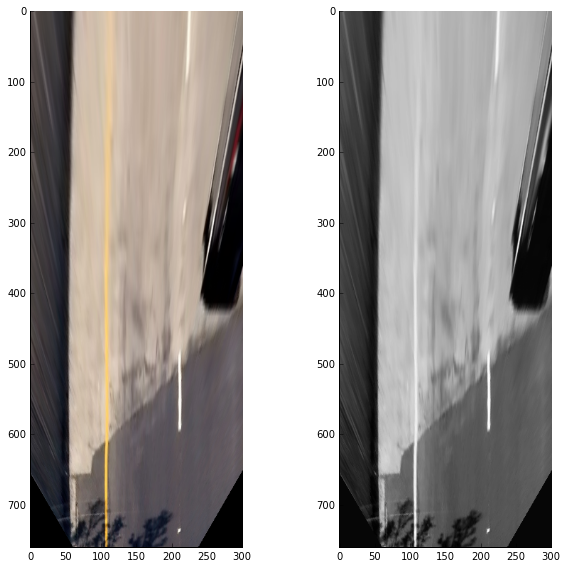

In [48]:
test_img = get_test_image(3, resize=False, hard=False)
test_img, _ = cc.undistort(test_img, False)
warped = bev.warp(test_img)
mask_rgb = bev.build_mask(test_img)
mask = mask_rgb[..., 0]

gray, lab_warped = lab_enhance_yellow(warped)
show_two_images(warped, gray)

In [212]:
test = np.array([1., 0., 0.], np.float32).reshape((1, 1,  3))
cv2.cvtColor(test, cv2.COLOR_BGR2LAB).reshape(-1).tolist()

[32.293701171875, 79.1875, -107.859375]

In [220]:
def lab_enhance_yellow_2(img: np.ndarray, power: float=2, ypower: float=1) -> np.ndarray:
    img = np.float32(img) / 255
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    rg = (127 - lab[..., 1]) / 256
    yb = (127 - lab[..., 2]) / 256
    
    yb[yb < 0.4] = 0  # suppress blue
    yb[rg < 0.2] = 0  # suppress red
    yb[rg > 0.8] = 0  # suppress green
        
    if ypower != 1:
        yb = yb ** ypower
        
    # Normalize "yellow channel" to 0..1
    cv2.normalize(yb, yb, 1, norm_type=cv2.NORM_MINMAX)
        
    # OpenCV L*a*b*'s L is 0..100 
    gray = lab[..., 0] / 100
    if power != 1:
        gray = gray ** power
    
    # Whatever is brighter is our pixel value.
    mixed = cv2.max(gray, yb)
    cv2.normalize(mixed, mixed, 1, norm_type=cv2.NORM_MINMAX)

    lab[..., 0] = mixed * 100
    return mixed, lab

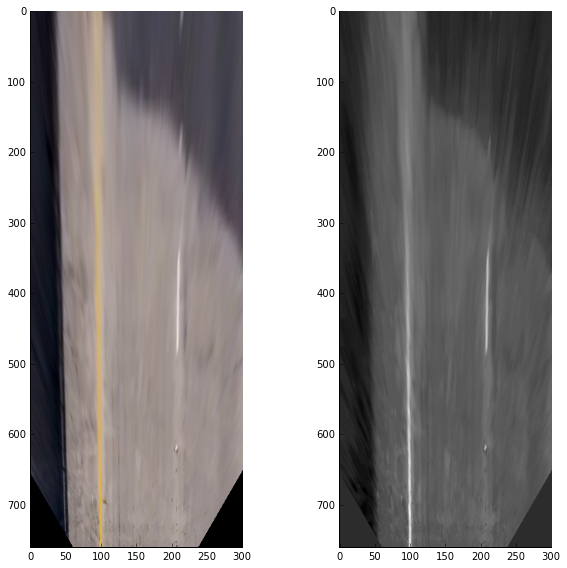

In [221]:
test_img = get_test_image(8, resize=False, hard=False)
test_img, _ = cc.undistort(test_img, False)
warped = bev.warp(test_img)
mask_rgb = bev.build_mask(test_img)
mask = mask_rgb[..., 0]

gray, lab_warped = lab_enhance_yellow_2(warped, power=2)
show_two_images(warped, gray, vmin=0, vmax=1)

In [148]:
def edges(gray: np.ndarray, normalize: bool=True, mask: Optional[np.ndarray]=None) -> np.ndarray:
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    dx = cv2.Sobel(gray, 3, 1, 0)
    dy = cv2.Sobel(gray, 3, 0, 1)   
    edges = np.sqrt(dx ** 2 + dy ** 2)
    if mask is not None:
        edges *= cv2.erode(mask, np.ones((3, 3), np.float32))
    if not normalize:
        return edges
    cv2.normalize(edges, edges, 1, norm_type=cv2.NORM_MINMAX)
    return edges

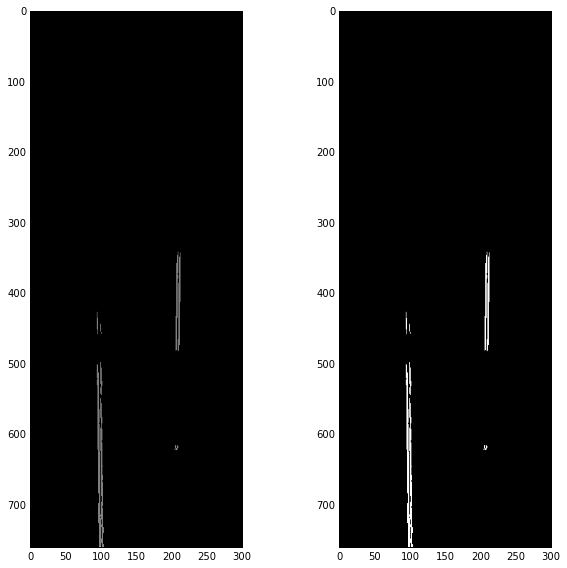

In [149]:
show_two_images(edges(gray, mask=mask), edges(gray, False, mask), vmin=0, vmax=1)

Pyramid at (760, 300)
Pyramid at (570, 225)
Pyramid at (428, 169)
Pyramid at (321, 127)
Pyramid at (241, 95)
Pyramid at (181, 71)
Pyramid at (136, 53)
Pyramid at (102, 40)
Pyramid at (76, 30)
Pyramid at (57, 22)


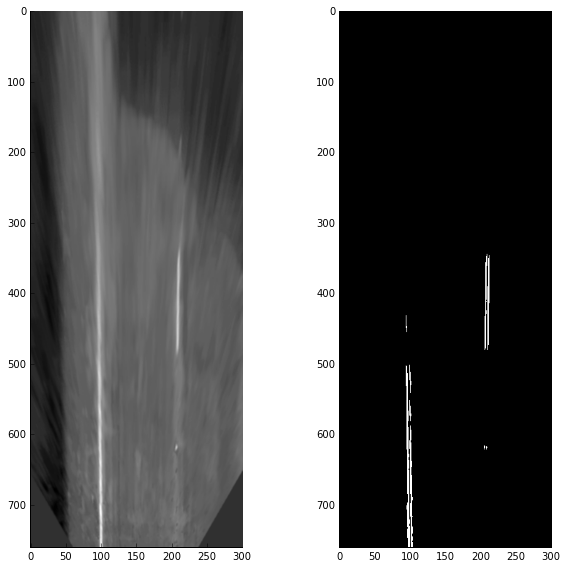

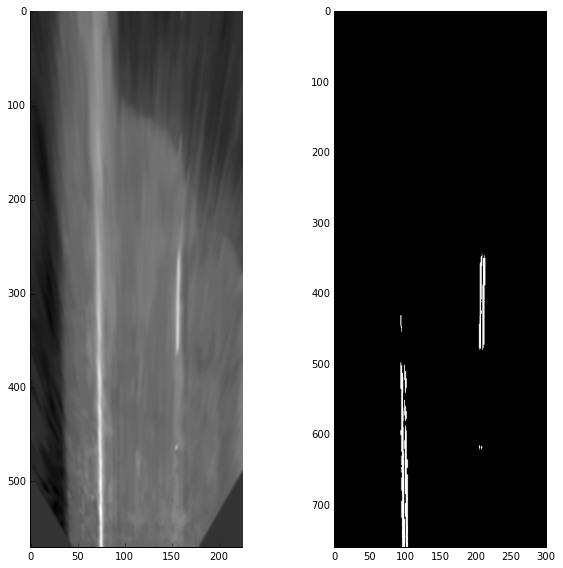

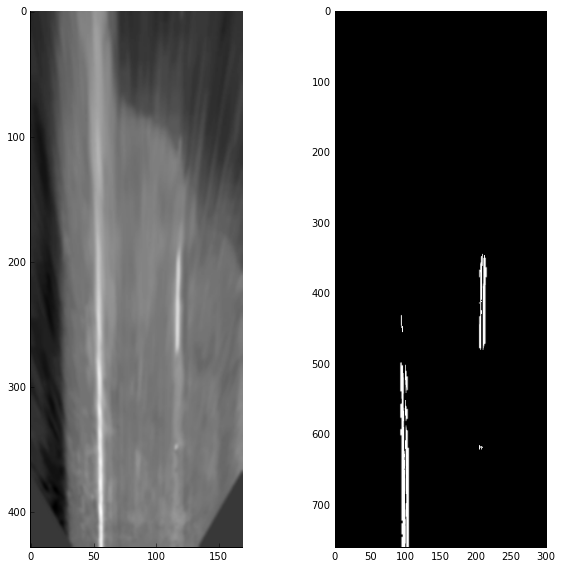

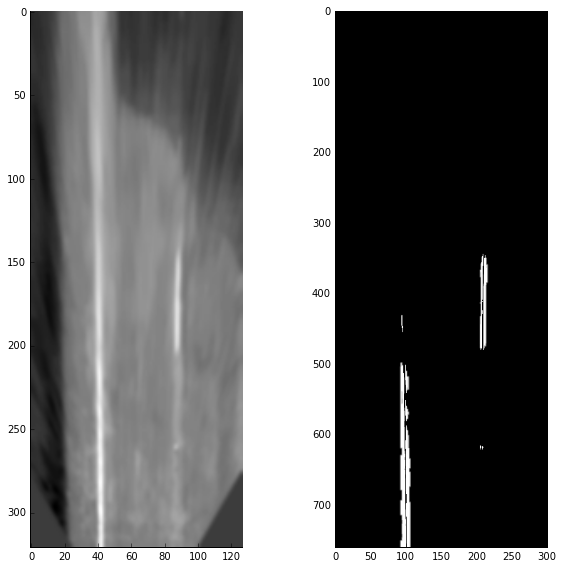

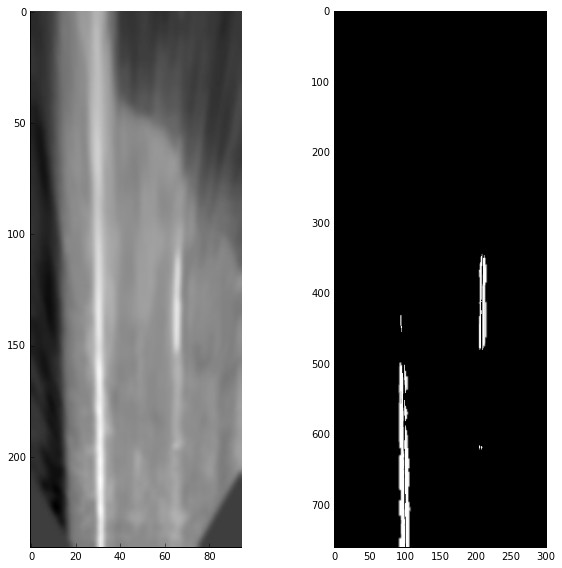

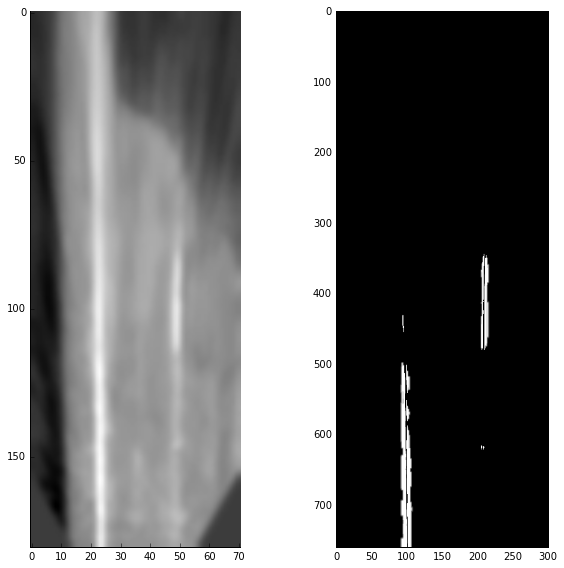

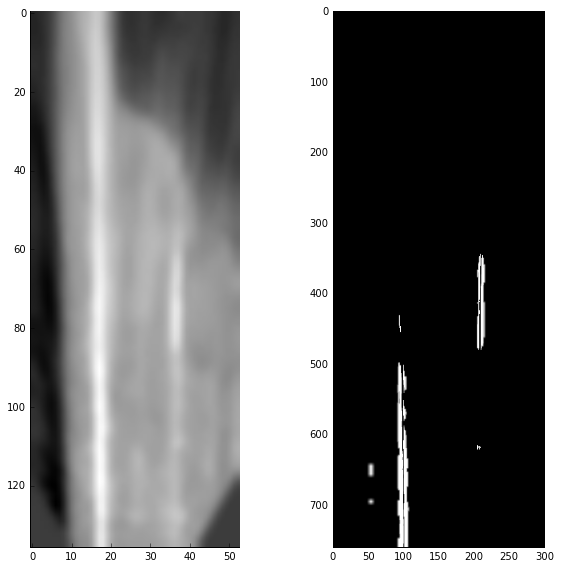

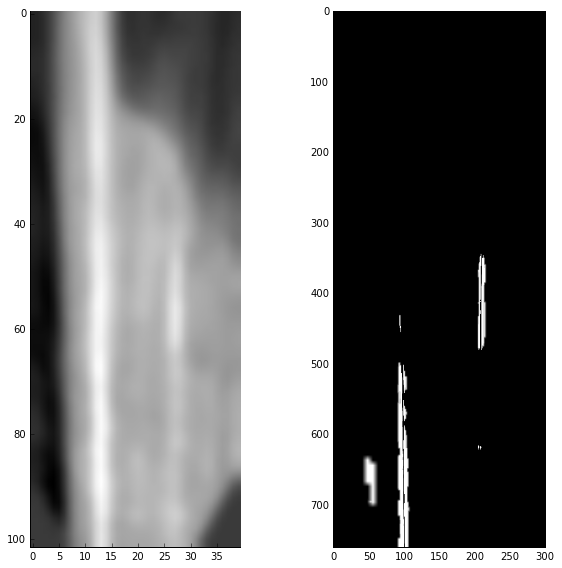

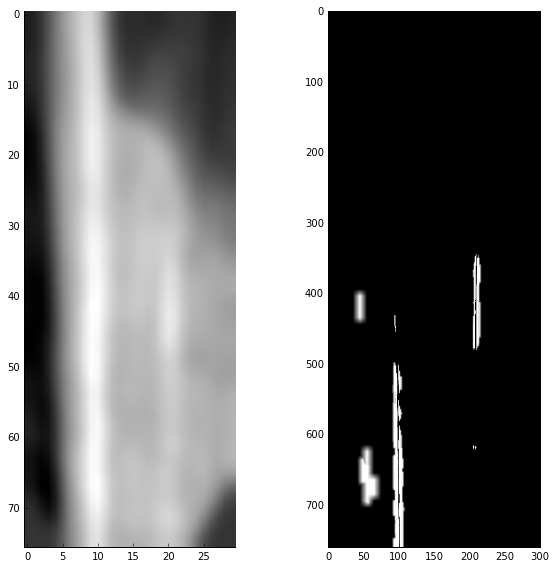

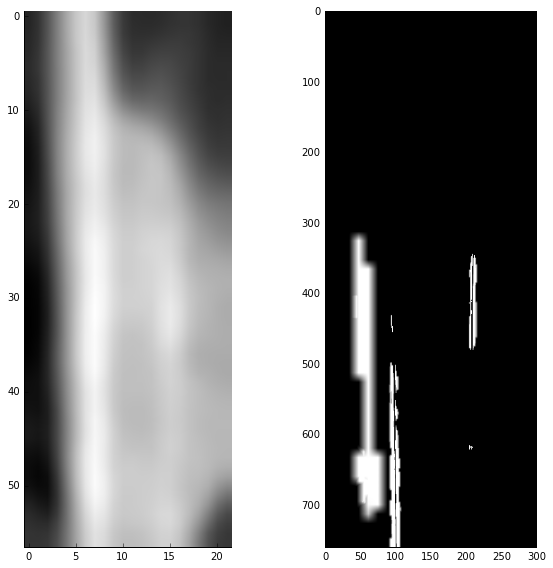

In [150]:
accumulator = np.zeros_like(gray)

scale, scale_mask = gray, mask
h, w = gray.shape[:2]
sx = .75

for s in range(10):
    if s > 0:
        scale = cv2.resize(scale, (0, 0), fx=sx, fy=sx)
        scale_mask = cv2.resize(scale_mask, (0, 0), fx=sx, fy=sx, interpolation=cv2.INTER_LINEAR)
    print('Pyramid at', scale.shape)
    
    scale = cv2.GaussianBlur(scale, (3, 3), 0)
    scale = scale - np.mean(scale)
    scale_edges = edges(scale, mask=scale_mask)
    accumulator = cv2.max(accumulator, cv2.resize(scale_edges, (w, h)))
    
    show_two_images(scale, accumulator.copy())

## Using a Line Segment Detector

0 240


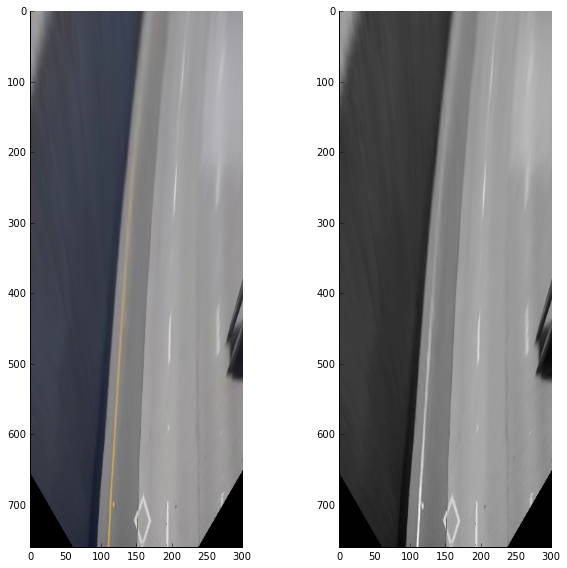

In [181]:
test_img = get_test_image(8, resize=False, hard=True)
test_img, _ = cc.undistort(test_img, False)
warped = bev.warp(test_img)
mask_rgb = bev.build_mask(test_img)
mask = mask_rgb[..., 0]

gray, lab_warped = lab_enhance_yellow(warped)
show_two_images(warped, gray)

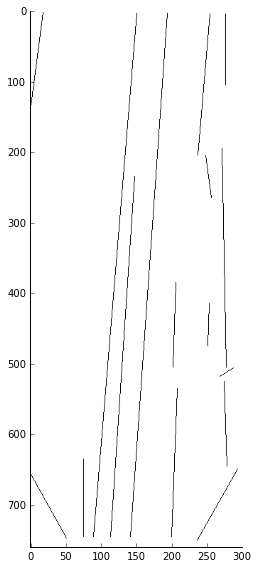

In [182]:
lsd = cv2.createLineSegmentDetector(cv2.LSD_REFINE_STD, 0.1)
lines = lsd.detect(np.uint8(gray * 255))
drawn_img = lsd.drawSegments(np.ones_like(gray), lines[0])
show_single_image(drawn_img)

## Pattern matching

0 255


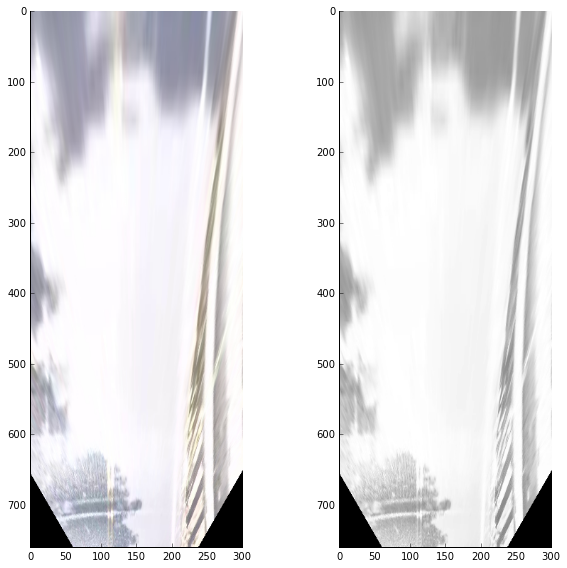

In [183]:
test_img = get_test_image(3, resize=False, hard=True)
test_img, _ = cc.undistort(test_img, False)
warped = bev.warp(test_img)
mask_rgb = bev.build_mask(test_img)
mask = mask_rgb[..., 0]

gray, lab_warped = lab_enhance_yellow(warped)
show_two_images(warped, gray)

### Positive templates

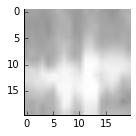

In [184]:
def pick_window(img: np.ndarray, x: int, y: int, width: int=20, height: int=20) -> np.ndarray:
    return img[y:y+height, x:x+width]

template_1 = pick_window(gray, 103, 700)
show_single_image(template_1, size=(2, 2), vmin=0, vmax=1)

In [185]:
%%timeit
cv2.matchTemplate(gray, template_1, cv2.TM_CCOEFF_NORMED)

10.5 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


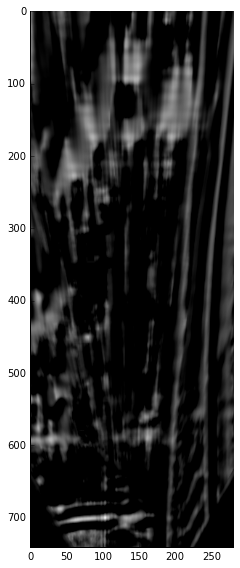

In [186]:
matches_p1 = cv2.matchTemplate(gray, template_1, cv2.TM_CCOEFF_NORMED)
matches_p1[matches_p1 < 0] = 0
show_single_image(matches_p1)

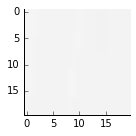

In [187]:
template_2 = pick_window(gray, 186, 450)
show_single_image(template_2, size=(2, 2), vmin=0, vmax=1)

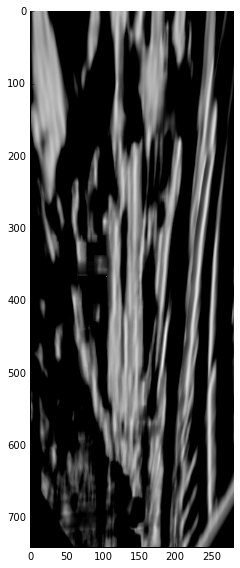

In [188]:
matches_p2 = cv2.matchTemplate(gray, template_2, cv2.TM_CCOEFF_NORMED)
matches_p2[matches_p2 < 0] = 0
show_single_image(matches_p2)

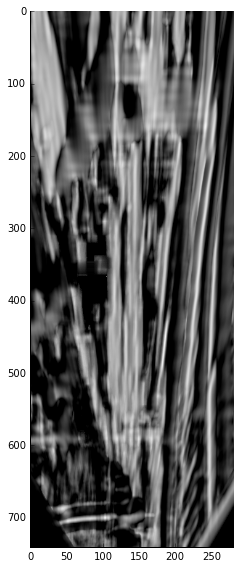

In [189]:
positive = (matches_p1 + matches_p2) / 2
show_single_image(positive)

### Negative templates

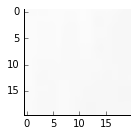

In [190]:
negative_1 = pick_window(gray, 143, 650)
show_single_image(negative_1, size=(2, 2), vmin=0, vmax=1)

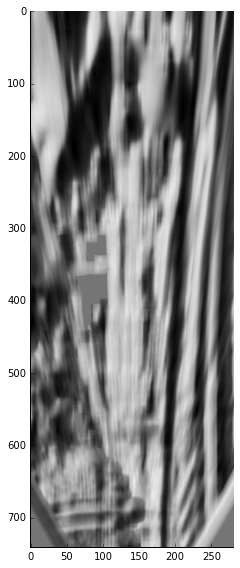

In [191]:
matches_n1 = cv2.matchTemplate(gray, negative_1, cv2.TM_CCOEFF_NORMED)
show_single_image(matches_n1)

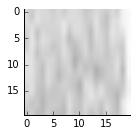

In [192]:
negative_2 = pick_window(gray, 90, 650)
show_single_image(negative_2, size=(2, 2), vmin=0, vmax=1)

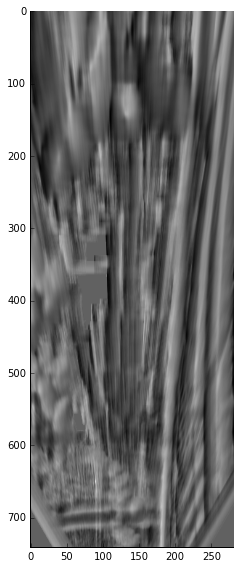

In [193]:
matches_n2 = cv2.matchTemplate(gray, negative_2, cv2.TM_CCOEFF_NORMED)
show_single_image(matches_n2)

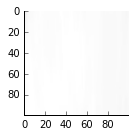

In [194]:
negative_3 = pick_window(gray, 80, 200, 100, 100)
show_single_image(negative_3, size=(2, 2), vmin=0, vmax=1)

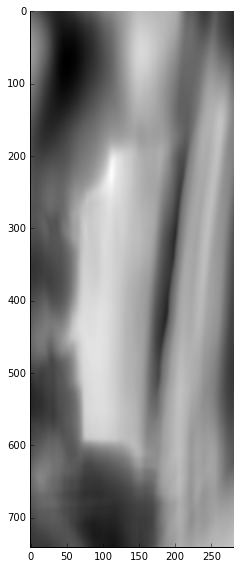

In [195]:
matches_n3 = cv2.matchTemplate(gray, negative_3, cv2.TM_CCOEFF_NORMED)
matches_n3 = cv2.resize(matches_n3, (matches_n2.shape[1], matches_n2.shape[0]))
show_single_image(matches_n3)

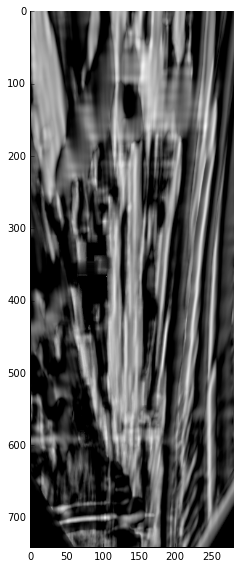

In [196]:
negative = matches_n1 * matches_n2 * matches_n3
show_single_image((1 - negative) * positive)

In [197]:
def process(gray: np.ndarray, mode: int=cv2.TM_CCOEFF_NORMED) -> np.ndarray:
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    matches_p1 = cv2.matchTemplate(gray, template_1, mode)
    matches_p1[matches_p1 < 0] = 0    
    matches_p2 = cv2.matchTemplate(gray, template_2, mode)
    matches_p2[matches_p2 < 0] = 0
    
    matches_n1 = cv2.matchTemplate(gray, negative_1, mode)
    matches_n1[matches_n1 < 0] = 0
    matches_n2 = cv2.matchTemplate(gray, negative_2, mode)
    matches_n2[matches_n2 < 0] = 0
    matches_n3 = cv2.matchTemplate(gray, negative_3, mode)
    matches_n3[matches_n3 < 0] = 0
    matches_n3 = cv2.resize(matches_n3, (matches_n2.shape[1], matches_n2.shape[0]))
    
    positive = (matches_p1 + matches_p2) / 2
    negative = matches_n1 * matches_n2 * matches_n3
    
    mask = (1 - negative) * positive
    mask[mask < 0] = 0
    mask = cv2.normalize(mask, 1, cv2.NORM_MINMAX)
    return mask

0 255


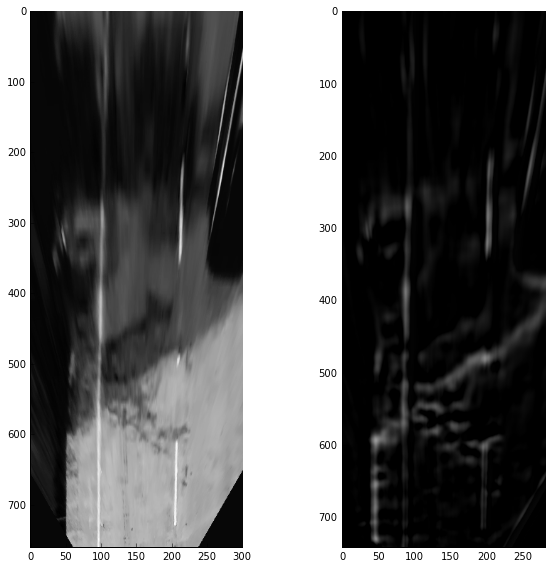

In [198]:
test_img = get_test_image(4, resize=False, hard=False)
test_img, _ = cc.undistort(test_img, False)
warped = bev.warp(test_img)
mask_rgb = bev.build_mask(test_img)
mask = mask_rgb[..., 0]

gray, lab_warped = lab_enhance_yellow(warped)
show_two_images(gray, process(gray, cv2.TM_CCOEFF), vmin=0, vmax=1)

0 255


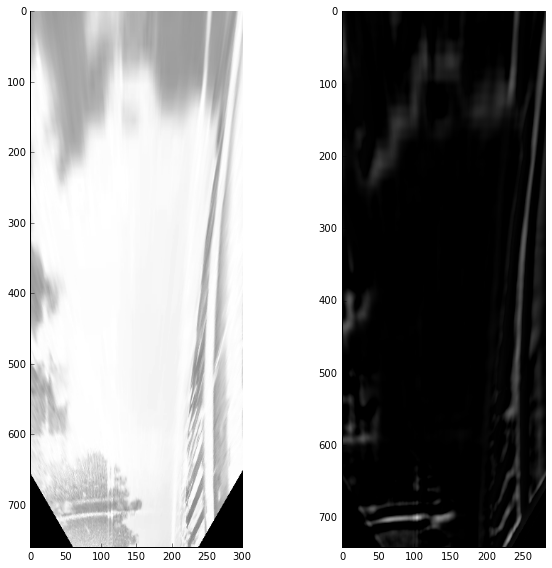

In [199]:
test_img = get_test_image(3, resize=False, hard=True)
test_img, _ = cc.undistort(test_img, False)
warped = bev.warp(test_img)
mask_rgb = bev.build_mask(test_img)
mask = mask_rgb[..., 0]

gray, lab_warped = lab_enhance_yellow(warped)
show_two_images(gray, process(gray, cv2.TM_CCOEFF), vmin=0, vmax=1)

0 255


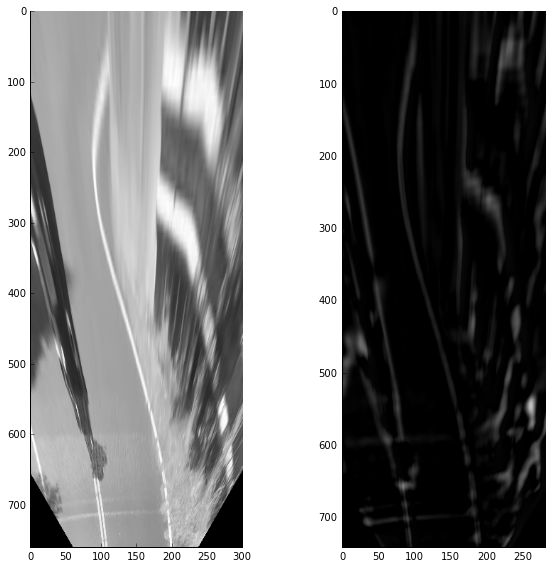

In [200]:
test_img = get_test_image(6, resize=False, hard=True)
test_img, _ = cc.undistort(test_img, False)
warped = bev.warp(test_img)
mask_rgb = bev.build_mask(test_img)
mask = mask_rgb[..., 0]

gray, lab_warped = lab_enhance_yellow(warped)
show_two_images(gray, process(gray, cv2.TM_CCOEFF), vmin=0, vmax=1)